# 3. Características espaciales de las roturas y su influencia en la superfície

#### - Explora las características espaciales de las grandes roturas (salto en el plano de falla, propagación de la rotura)
#### - Observa las características de las roturas en superfície, su comportamiento (característico, variable) y la influencia de la geometria


In [2]:
#Import the necessary libraries

#%matplotlib widget
import ipympl
import os
import json
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter

### Selecciona la carpeta correspondiente a cada uno de los modelos dentro de la carpeta "Catalogues"

In [9]:
# Extract the catalogue

cat = "Listrica_planar" #Pon aquí el nombre de la carpeta del catálogo correspondiente

path = os.getcwd()
path = os.path.abspath(os.path.join(path, "../"+ "/Catalogues/"))
path = path+"/"+cat

file = os.path.join(path, "data.json")
with open(file, "r") as file:
    catalog = json.load(file)

Ev_per_patch = {key: catalog[key] for key in catalog.keys() & {"eList", "pList", "dList", "tList", "dtauList", "M", "M0", "area", "x", "y", "z"}}

# Filter events by year number

cut_year = 20000
t0_ini = list(catalog.values())[-2]
z_ini = Ev_per_patch.get("z")
loc_cut = np.where(np.array(t0_ini)>cut_year)[0][0]
M_ini = np.array(Ev_per_patch.get("M"))[loc_cut:]
M_ini = [float(i) for i in M_ini]
M0_ini = np.array(Ev_per_patch.get("M0"))[loc_cut:]
M0_ini = [float(i) for i in M0_ini]
area_ini = np.array(Ev_per_patch.get("area"))[loc_cut:]
num_events_ini = list(range(1, len(M_ini)+1))+loc_cut
x_ini = np.array(Ev_per_patch.get("x"))[loc_cut:]
y_ini = np.array(Ev_per_patch.get("y"))[loc_cut:]
z_ini = np.array(Ev_per_patch.get("z"))[loc_cut:]
Depth_ini = np.array(Ev_per_patch.get("z"))[loc_cut:]
t0_ini = np.array(t0_ini)[loc_cut:]

eList_ini = Ev_per_patch.get("eList")
loc_list_cut = np.where(np.array(eList_ini)==num_events_ini[0])[0][0]
eList_ini = np.array(eList_ini)[loc_list_cut:]
pList_ini = np.array(Ev_per_patch.get("pList"))[loc_list_cut:]
dList_ini = np.array(Ev_per_patch.get("dList"))[loc_list_cut:]
dtauList_ini = np.array(Ev_per_patch.get("dtauList"))[loc_list_cut:]
tList_ini = np.array(Ev_per_patch.get("tList"))[loc_list_cut:]

# Completness

mag_range = np.arange(0, 8, 0.1)
hist1, bins = np.histogram(M_ini, bins=mag_range)
Mc = bins[np.argmax(hist1)]
Mc_2 = Mc

idx_Mc = [x > Mc_2 for x in M_ini]
M_ini = (np.array(M_ini))[idx_Mc]
M0_ini = (np.array(M0_ini))[idx_Mc]
area_ini = (np.array(area_ini))[idx_Mc]
num_events_ini = (np.array(num_events_ini))[idx_Mc]
t0_ini = (np.array(t0_ini))[idx_Mc]
x_ini = (np.array(x_ini))[idx_Mc]
y_ini = (np.array(y_ini))[idx_Mc]
z_ini= (np.array(z_ini))[idx_Mc]

idx_Mc_all = np.where(np.isin(eList_ini, num_events_ini))[0]
eList_ini = np.float64((np.array(eList_ini))[idx_Mc_all])
pList_ini = np.float64((np.array(pList_ini))[idx_Mc_all])
dList_ini = np.float64((np.array(dList_ini))[idx_Mc_all])
dtauList_ini = np.float64((np.array(dtauList_ini))[idx_Mc_all])
tList_ini = np.float64((np.array(tList_ini))[idx_Mc_all])

Event_list = np.column_stack((eList_ini, pList_ini, dList_ini, dtauList_ini, tList_ini))
Moment_release = np.column_stack((M_ini, M0_ini, area_ini, t0_ini, num_events_ini))


fault = os.path.join(path + "/fault.flt")

if cat == "Sistema_EBSZ":
    input_file = pd.read_csv(fault, delimiter=";", header=None)
    input_file.iloc[:,0:8] = input_file.iloc[:,0:8]*1000
else:
    input_file = pd.read_csv(fault, delimiter=" ", header=None)

u_flt, locs_flt = np.unique(input_file.iloc[:, -1], return_index=True)
locs_flt = np.concatenate((locs_flt, np.array([len(input_file) + 1])))

x1 = input_file.iloc[:, 0]
x2 = input_file.iloc[:, 3]
x3 = input_file.iloc[:, 6]
y1 = input_file.iloc[:, 1]
y2 = input_file.iloc[:, 4]
y3 = input_file.iloc[:, 7]
z1 = input_file.iloc[:, 2]
z2 = input_file.iloc[:, 5]
z3 = input_file.iloc[:, 8]

file = np.column_stack((x1, x2, x3, y1, y2, y3, z1, z2, z3, np.array(range(1, len(input_file) + 1))))

x_center = (file[:, 0] + file[:, 1] + file[:, 2]) / 3
y_center = (file[:, 3] + file[:, 4] + file[:, 5]) / 3
z_center = (file[:, 6] + file[:, 7] + file[:, 8]) / 3

# Find patches that are located at the surface

init_depth = 0
con_2 = (file[:, 6] >= init_depth) & (file[:, 7] >= init_depth)
con_3 = (file[:, 7] >= init_depth) & (file[:, 8] >= init_depth)
con_4 = (file[:, 6] >= init_depth) & (file[:, 8] >= init_depth)
con_2 = np.where(con_2)[0]
con_3 = np.where(con_3)[0]
con_4 = np.where(con_4)[0]

# Find patches that are located between 0 and mean_depth km

z_1 = np.concatenate((con_2, con_3, con_4))
z_filter, reps = np.unique(z_1, return_index=False, return_counts=True)

### Determina una magnitud de corte y explora las características espaciales de cada rotura en el plano de falla

/Users/octavigono/opt/anaconda3/envs/cursoSHA/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


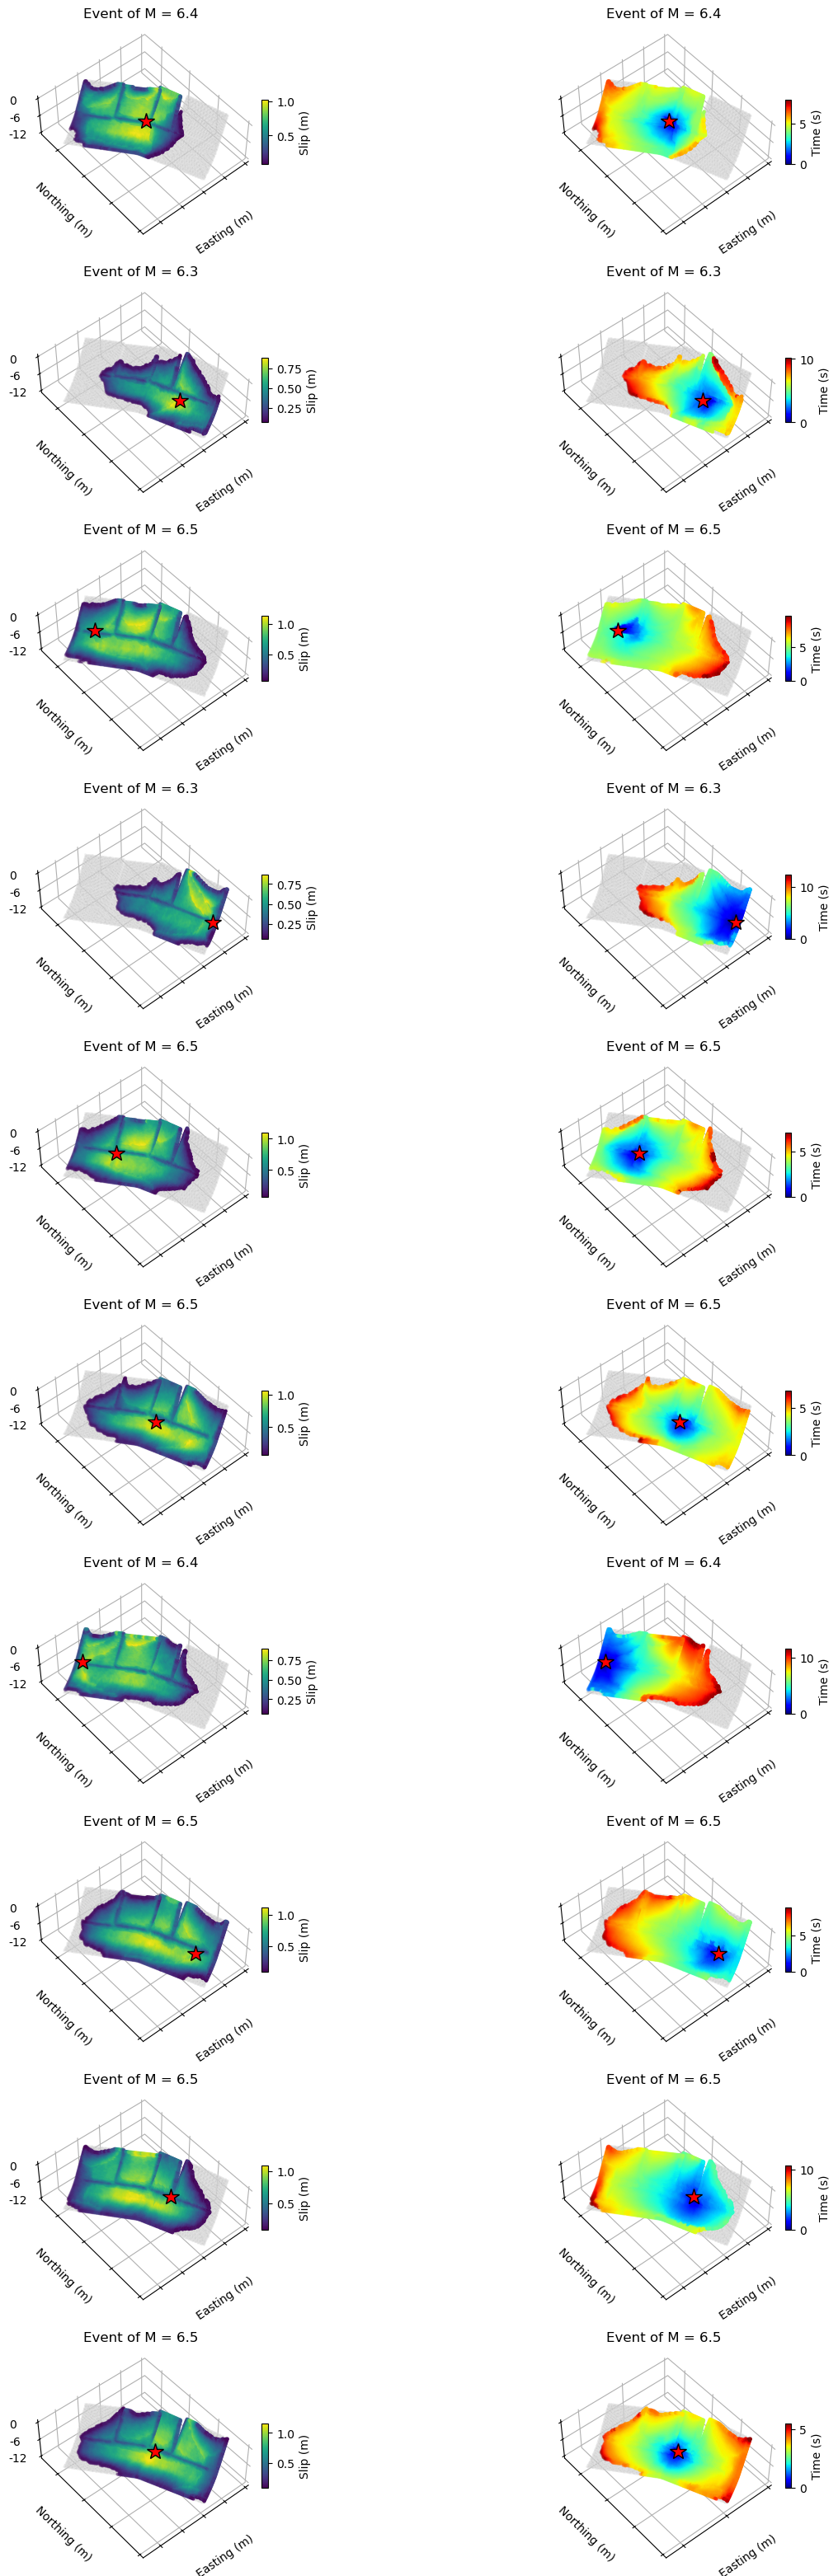

In [10]:
#Analyze the characteristics of large magnitudes

magnitude_cutoff = 6.0  # Set magnitude threshold
num_events = 10  # Set number of events you want to visualize

locs_M = np.where(M_ini >= magnitude_cutoff)[0]
ev_filt = num_events_ini[locs_M]

eList_filt = [np.where(eList_ini == i)[0] for i in ev_filt]
eList_filt = np.array([val for sublist in eList_filt for val in sublist])

pList_filt = pList_ini[eList_filt]
dList_filt = dList_ini[eList_filt]
tList_filt = tList_ini[eList_filt]
eList_filt = eList_ini[eList_filt]

la = -1

loc_M = np.where(M_ini >= magnitude_cutoff)[0]
num_evs = num_events_ini[loc_M]
row_height = 4  # Altura por fila (en pulgadas)
fig_width = 15  # Anchura fija para 2 columnas
fig_height = num_events * row_height
fig, ax = plt.subplots(num_events, 2, figsize=(fig_width, fig_height), subplot_kw=dict(projection='3d'), constrained_layout=True)

for ja in range(len(x_ini[loc_M][0:num_events])):
    eList_loc = np.where(eList_ini == num_evs[ja])[0]
    dList_slip = dList_ini[eList_loc]
    pList_slip = pList_ini[eList_loc]
    pList_slip = np.array([int(i) for i in pList_slip])
    tList_slip = tList_ini[eList_loc]
    la = la + 1
    ax[la, 0].plot(x_center, y_center, z_center, marker="o", linestyle="", color="grey", markersize=2, alpha=0.1, markeredgecolor="w")
    ax[la, 1].plot(x_center, y_center, z_center, marker="o", linestyle="", color="grey", markersize=2, alpha=0.1, markeredgecolor="w")
    br = ax[la, 0].scatter(x_center[pList_slip-1], y_center[pList_slip-1], z_center[pList_slip-1], s=5, c=dList_slip, cmap="viridis")
    ba = ax[la, 1].scatter(x_center[pList_slip-1], y_center[pList_slip-1], z_center[pList_slip-1], s=5, c=tList_slip-min(tList_slip), cmap="jet")
    ax[la, 0].plot(x_ini[loc_M][ja], y_ini[loc_M][ja], z_ini[loc_M][ja], marker="*", linestyle="", markersize=15, markeredgecolor='black', color='red', zorder=10)
    ax[la, 1].plot(x_ini[loc_M][ja], y_ini[loc_M][ja], z_ini[loc_M][ja], marker="*", linestyle="", markersize=15, markeredgecolor='black', color='red', zorder=10)
    
    if cat == "Sistema_Grecia":
        ax[la,0].view_init(50)
        ax[la,1].view_init(50)
    elif cat == "Sistema_EBSZ":
        ax[la,0].view_init(50, -90)
        ax[la,1].view_init(50, -90)
    else:
        ax[la,0].view_init(50, -130)
        ax[la,1].view_init(50, -130)
        
    plt.locator_params(axis='both', nbins=4)
    cbar = fig.colorbar(br, shrink=0.3, aspect=10, pad=.03)
    cbar.ax.set_ylabel("Slip (m)")
    cbar1 = fig.colorbar(ba, shrink=0.3, aspect=10, pad=.03)
    cbar1.ax.set_ylabel("Time (s)")
    
    ax[la, 0].set_xlabel("Easting (m)")
    ax[la, 0].set_ylabel("Northing (m)")
    ax[la, 0].set_title("Event of M = " + str(round(M_ini[loc_M][ja], 1)))
    ax[la, 0].set_aspect("equalyz")
    
    ax[la, 1].set_xlabel("Easting (m)")
    ax[la, 1].set_ylabel("Northing (m)")
    ax[la, 1].set_title("Event of M = " + str(round(M_ini[loc_M][ja], 1)))
    ax[la, 1].set_aspect("equalyz")
    
    ax[la, 0].set_xticklabels("")
    ax[la, 0].set_yticklabels("")
    ax[la, 1].set_xticklabels("")
    ax[la, 1].set_yticklabels("")
    ax[la, 1].set_zticklabels("")
    
    ax[la, 0].set_zticks([-12000, -6000, 0])
    ax[la, 0].set_zticklabels([-12, -6, 0])
    ax[la, 1].set_zticks([-12000, -6000, 0])
    ax[la, 1].set_zticklabels("")

    ax[la, 0].xaxis.pane.set_visible(False)
    ax[la, 0].yaxis.pane.set_visible(False)
    ax[la, 0].zaxis.pane.set_visible(False)
    ax[la, 1].xaxis.pane.set_visible(False)
    ax[la, 1].yaxis.pane.set_visible(False)
    ax[la, 1].zaxis.pane.set_visible(False)
    
plt.show()

#### Observa la frecuencia de roturas en superfície en el catálogo y en función de la magnitud.

/var/folders/pr/ntkh6s1x72d9ql6tyqk64z5w0000gn/T/ipykernel_90803/396845379.py:71: RuntimeWarning: invalid value encountered in scalar divide
  perc_surf = np.array([(h1 / h2) for h1, h2 in zip(hist_surf, hist_M)])


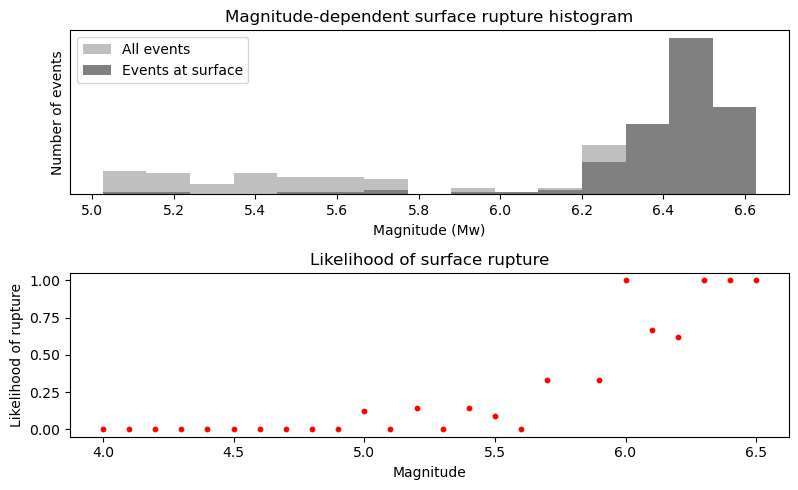

In [11]:
#Identify surface patches

init_depth = 0
con_2 = (file[:, 6] >= init_depth) & (file[:, 7] >= init_depth)
con_3 = (file[:, 7] >= init_depth) & (file[:, 8] >= init_depth)
con_4 = (file[:, 6] >= init_depth) & (file[:, 8] >= init_depth)
con_2 = np.where(con_2)[0]
con_3 = np.where(con_3)[0]
con_4 = np.where(con_4)[0]

z_1 = np.concatenate((con_2, con_3, con_4))
z_filter, reps = np.unique(z_1, return_index=False, return_counts=True)

x_surface_patch = x_center[z_filter]
y_surface_patch = y_center[z_filter]
z_surface_patch = z_center[z_filter]
coords_patch = np.column_stack((x_surface_patch, y_surface_patch, z_surface_patch))

#Calculate along strike distances

segments, idx_segm = np.unique(input_file.iloc[z_filter,12], return_index=True)
idx_segm = np.array(list(idx_segm)+[len(x_surface_patch)])

dist_strike_all = [[0]] #First point is always 0
ci=0
sorts_all = []
indexes_sort = np.array(list(range(0, len(y_surface_patch))))
for ks in idx_segm[:-1]:
    ci=ci+1
    id = idx_segm[ci]
    dist_strike = []
    sort_y = np.argsort(y_surface_patch[ks:id])
    sorts_all.append(indexes_sort[ks:id][np.flip(sort_y)])
    sort_x_surface_patch = x_surface_patch[ks:id][sort_y]
    if id!=len(x_surface_patch):
        sort_y_adv = np.argsort(y_surface_patch[id:idx_segm[ci + 1]])
        sort_x_adv = x_surface_patch[id:idx_segm[ci + 1]][sort_y_adv]
        x_inter_first = sort_x_surface_patch[0]
        x_inter_last = sort_x_adv[-1]
        y_inter_first = y_surface_patch[ks:id][sort_y][0]
        y_inter_last = y_surface_patch[id:idx_segm[ci + 1]][sort_y_adv][-1]
        distance = math.sqrt((x_inter_last-x_inter_first)**2+(y_inter_last-y_inter_first)**2)
    for km in range(len(x_surface_patch[ks:id])-1):
        dist = math.sqrt((sort_x_surface_patch[km+1]-sort_x_surface_patch[km])**2 + (sorted(y_surface_patch[ks:id])[km+1]-sorted(y_surface_patch[ks:id])[km])**2)
        dist_strike.append(dist)
        if (km == len(x_surface_patch[ks:id])-2) and (id!=len(x_surface_patch)):
            dist_strike.append(distance)
    dist_strike_all.append(dist_strike)

dist_strike_all = [item for row in dist_strike_all for item in row]
cum_dist_strike =  np.cumsum(dist_strike_all)
cum_dist_strike = np.flip(abs(cum_dist_strike-max(cum_dist_strike)))
sorts_all = [item for row in sorts_all for item in row]

# Read eqs at surface
surface_patches = file[z_filter, -1]
events_surface = Event_list[np.isin(Event_list[:, 1], surface_patches)]
events_surface[:, -1] /= (365 * 24 * 3600)
uni_ev, idx_uni = np.unique(events_surface[:, 0], return_inverse=True)
idx_M = np.where(np.isin(eList_ini, uni_ev))[0]
Surf = Moment_release[np.isin(Moment_release[:, -1], uni_ev)]
M_surface = Surf[:, 0]
t_surf = Surf[:, 3]
Slip_eve_surface = Surf[:, 1]
M_cutoff_hist = np.where(M_surface >  5)[0]
M_surface_cutoff = M_surface[M_cutoff_hist]
bins =  np.arange(4, round(max(M_ini), 1) + 0.1, 0.1)

hist_surf,_ = np.histogram(M_surface_cutoff, bins)
hist_M, _ = np.histogram(M_ini, bins)
perc_surf = np.array([(h1 / h2) for h1, h2 in zip(hist_surf, hist_M)])


#Plot histogram of surface ruptures
fig2, ax2 = plt.subplots(2,1, figsize=(8,5))
ax2[0].hist(M_ini[np.array(M_ini)>=min(M_surface[M_cutoff_hist])], bins=15, stacked=True, zorder=1, color="grey", alpha = 0.5)
ax2[0].hist(M_surface[M_cutoff_hist], bins=15, stacked=True, zorder=2, color="grey")
ax2[0].set_ylabel("Number of events")
ax2[0].set_xlabel("Magnitude (Mw)")
ax2[0].legend(["All events", 'Events at surface'])
ax2[0].set_yticks([])
ax2[0].set_title("Magnitude-dependent surface rupture histogram")
ax2[1].scatter(bins[:-1], perc_surf, c="red", s=10)
ax2[1].set_xlabel("Magnitude")
ax2[1].set_ylabel("Likelihood of rupture")
ax2[1].set_title("Likelihood of surface rupture")
plt.tight_layout()
plt.show()



#### A partir del histograma de magnitudes anterior selecciona una magnitud de corte y Visualiza los patrones de rotura en superfície para distintas roturas (modelos de falla única)

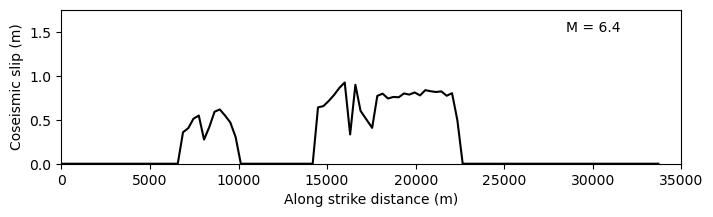

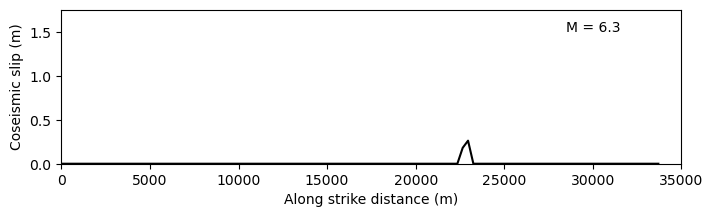

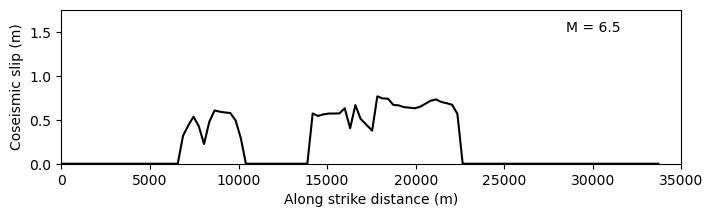

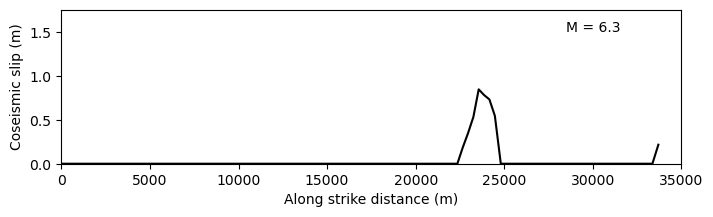

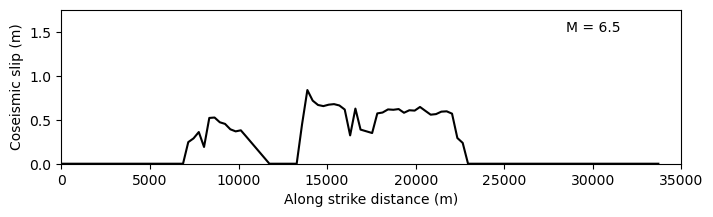

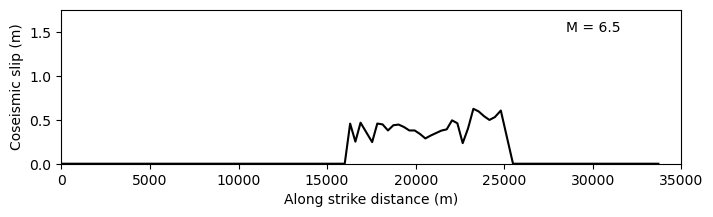

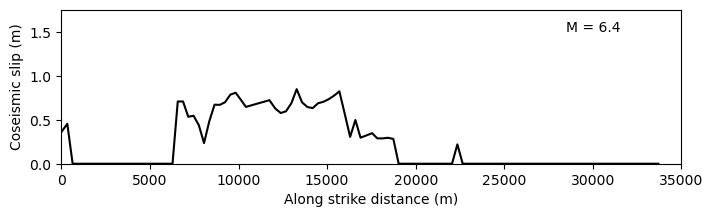

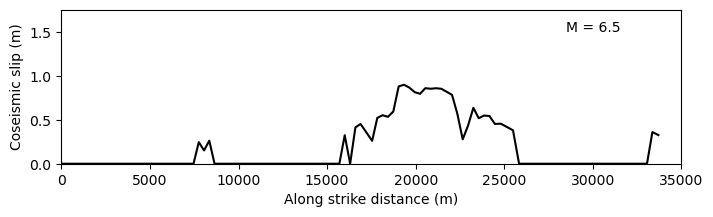

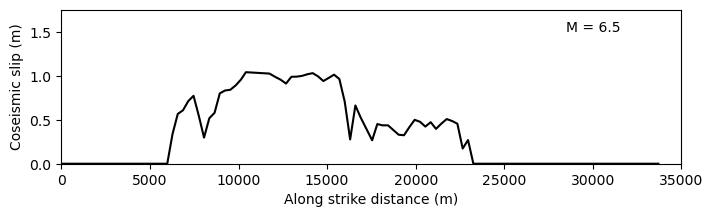

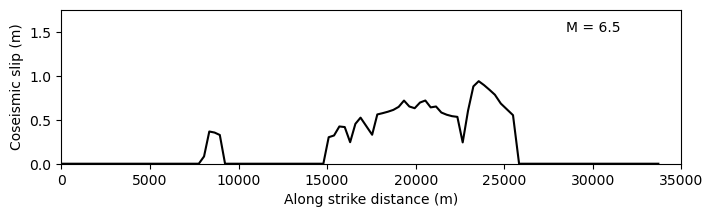

In [12]:
# Selecciona una magnitud de corte en base al histograma anterior

magnitude_cutoff = 6.0  # Set magnitude threshold
num_events = 10  # Set number of events you want to visualize

#Plot coseismic slip distribution along strike
M_cutoff = np.where((M_surface >  magnitude_cutoff) & (magnitude_cutoff <=  magnitude_cutoff+0.1))[0]
ci=-1
for sfs in uni_ev[M_cutoff][0:num_events]:
    ci=ci+1
    fig3, ax3 = plt.subplots(figsize=(8,2))
    event_at_surface = events_surface[np.isin(events_surface[:, 0], int(sfs)),:]
    slip_patch = event_at_surface[:, 2]
    slip_surf = np.zeros(len(x_surface_patch))
    patch_surf = event_at_surface[:, 1]
    sf = surface_patches[np.isin(surface_patches, patch_surf)]
    idx_sf = np.where(np.isin(surface_patches, sf))[0]
    slip_surf[idx_sf] = slip_patch
    coords_ev = coords_patch[idx_sf, :]
    ax3.plot(cum_dist_strike, slip_surf[np.flip(np.argsort(y_surface_patch))], c="black")
    ax3.set_xlim(0,35000)
    ax3.set_ylim(0,1.75)
    ax3.set_xlabel("Along strike distance (m)")
    ax3.set_ylabel("Coseismic slip (m)")
    ax3.text(30000, 1.5, "M = " + str(round(M_surface[M_cutoff][ci],1)), ha='center')
    plt.show()